In [1]:
%matplotlib inline
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio

In [2]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

# Algorithm Reconstruction

This file is a reconstruction of the algorithm proposed in __"Attention and P300-based BCI performance in people with
amyotrophic lateral sclerosis"__ for the identifying the characters focused by each subject during each trial.


__Data Description:__ https://lampx.tugraz.at/~bci/database/008-2014/description.pdf


## 1. Input Processing:

1. A Trial Signal Data($S_{Trial}(t)$) is a 8-channel EEG signal recorded from a subject while the subject was trying to focus on a single character on the P300 Speller Screen.


2. A Trial Target Data($Y_{Trial}(t)$) is the corresponding label at each point of time 't' for  $S_{Trial}(t)$ which indicates whether the stimulus being presented at that moment consisted the target(on focus) character or not.


3. A Trial Stimulus Data($Z_{Trial}(t)$) is the corresponding row/column no. of the P300 Speller Matrix which was being stimulated at each point of time 't'. This signal is provided as an input for training and test the classification algorithm. The main objective of the algorithm is to try and figure out which character(one row index and one column index) was being focused by the subject during the trial.

### Specifications:

- __Trial Signal Duration(t):__ 38sec

- __Trial Signal Shape:__ [9728 samples x 8 channels]

- __Sampling rate:__ 250Hz

- __Trial Stimulus Shape:__ [9728 samples x 1 value]

- __Duration when Trial Stimulus was presented:__ 3840 samples(15.36sec)

- __Trial Target Shape:__ [9728 samples x 1 class]

- __Duration for which Trial Target Class exists:__ 3840 samples(15.36sec)

- __Duration when no Trial Stimulus was presented(lag) and no Target Class exists:__ 5888 samples(23.552sec)

- __Stimulus Classes:__ 1-12(12) [0 indicates no stimulus was provided]

- __Target Classes:__ 1-2(2) [0 indicates no target exists]



In [3]:
# Functions for EEG data extraction and manipulation

# Get names of the available channels of the EEG recording.
def get_channel_names(sample_data):
    return sample_data[0][0]['channels'] 
        
# Get Output Classes from EEG data of the subject
def get_output_classes(sample_data):
    return sample_data[0][0]['y']

# Get Output Class names from EEG data of the subject
def get_output_names(sample_data):
    return sample_data[0][0]['classes']

# Get Stimulus Classes from EEG data of the subject
def get_stimulus_classes(sample_data):
    return sample_data[0][0]['y_stim']

# Get Stimulus Classe names from EEG data of the subject
def get_stimulus_names(sample_data):
    return sample_data[0][0]['classes_stim']

# Get trial start duration(sample point) from EEG data of the subject
def get_all_trials(sample_data):
    return sample_data[0][0]['trial']

# Get Gender of the subject
def get_subject_gender(sample_data):
    return sample_data[0][0]['gender']

# Get Age of the subject
def get_subject_age(sample_data):
    return sample_data[0][0]['age']

# Get ALSFRS of the subject
def get_subject_alsfrs(sample_data):
    return sample_data[0][0]['ALSfrs']

# Get disease onset of the subject
def get_subject_onset(sample_data):
    return sample_data[0][0]['onsetALS']


# Get EEG Signal from EEG data of the subject
def get_eeg_signal(sample_data, trial_no=0, return_output_classes=False, return_stim_classes=False):
    total_trials = get_all_trials(sample_data)
    if trial_no <= 0 or trial_no > total_trials.size:
        if (not return_output_classes) and (not return_stim_classes):
            return sample_data[0][0]['X']
        elif return_output_classes and (not return_stim_classes):
            return sample_data[0][0]['X'], get_output_classes(sample_data)
        elif return_stim_classes and (not return_output_classes):
            return sample_data[0][0]['X'], get_stimulus_classes(sample_data)
        else:
            return sample_data[0][0]['X'], get_output_classes(sample_data), get_stimulus_classes(sample_data)
    else:
        if trial_no < total_trials.size:
            trial_start = total_trials[0, trial_no-1]
            trial_end = total_trials[0, trial_no]
            
        else:
            trial_start = total_trials[0, trial_no-1]
            trial_end = sample_data[0][0]['X'].shape[0]
            
        if (not return_output_classes) and (not return_stim_classes):
            return sample_data[0][0]['X'][trial_start:trial_end, :]
        elif return_output_classes and (not return_stim_classes):
            return sample_data[0][0]['X'][trial_start:trial_end, :], get_output_classes(sample_data)[trial_start:trial_end, :] 
        elif return_stim_classes and (not return_output_classes):
            return sample_data[0][0]['X'][trial_start:trial_end, :], get_stimulus_classes(sample_data)[trial_start:trial_end, :]
        else:
            return sample_data[0][0]['X'][trial_start:trial_end, :], get_output_classes(sample_data)[trial_start:trial_end, :],  get_stimulus_classes(sample_data)[trial_start:trial_end, :]

 # Get a single trial data from the complete sample data. Each trial consists of stimulation of a single character.
# Therefore, each run has 5 trials since each word consists of 5 characters.
def get_trial_data(sample_data, trial_no, trial_end=None):
    if trial_no >= 0 and trial_no < sample_data[0][0]['trial'].size:
        new_sample_data = sample_data.copy()
        trial_start = sample_data[0][0]['trial'][0, trial_no]
        if trial_end is None:
            if trial_no < sample_data[0][0]['trial'].size-1:
                trial_end = sample_data[0][0]['trial'][0, trial_no+1]
            else:
                trial_end = sample_data[0][0]['X'].shape[0]
        new_sample_data[0][0]['X'] = new_sample_data[0][0]['X'][trial_start:trial_end, :]
        new_sample_data[0][0]['y'] = new_sample_data[0][0]['y'][trial_start:trial_end, :]
        new_sample_data[0][0]['y_stim'] = new_sample_data[0][0]['y_stim'][trial_start:trial_end, :]
        new_sample_data[0][0]['trial'] = np.asarray([[trial_start, trial_end]])
        return new_sample_data
    return sample_data


# Get a single run data from the complete sample data. Since each subject was asked to spell 7 words where each word
# consisted of 5 characters, total number of available runs for a single subject is 7.
def get_run_data(sample_data, run_no):
    total_runs = int(sample_data[0][0]['trial'].size/5)
    if run_no >= 0 and run_no < total_runs:
        new_sample_data = sample_data.copy()
        trial_start = sample_data[0][0]['trial'][0, run_no * 5]
        if run_no < total_runs-1:
            trial_end = sample_data[0][0]['trial'][0, (run_no * 5)+5]
        else:
            trial_end = sample_data[0][0]['X'].shape[0]
        new_sample_data[0][0]['X'] = new_sample_data[0][0]['X'][trial_start:trial_end, :]
        new_sample_data[0][0]['y'] = new_sample_data[0][0]['y'][trial_start:trial_end, :]
        new_sample_data[0][0]['y_stim'] = new_sample_data[0][0]['y_stim'][trial_start:trial_end, :]
        new_sample_data[0][0]['trial'] = np.asarray([[trial_start, trial_end]])
        return new_sample_data
    return sample_data

In [4]:
# Load EEG Signal of a subject and extract the trial signals from the data

#=================== a. Load File of the subject ================================================
data_dir = '../DataFiles'  # Folder containing the dataset
patient_file = 'A01.mat'  # File for the subject whose data needs to be loaded
sampling_rate = 256 # Hz [specified in data description]

file_path = os.path.join(data_dir, patient_file)  # URL for the sample data

sample_matlab_data = scio.loadmat(file_path)  # Structured Matlab Array containing all information

#===== b.Extract EEG Signal information and EEG Signal data of the subject from the Matlab Array.========

sample_data = sample_matlab_data['data']  # EEG Signal data for the subject
sample_data_keys = ['channels', 'X', 'y', 'y_stim', 'trial', 'classes', 'classes_stim',
                   'gender', 'age', 'ALSfrs', 'onsetALS']

for key in sample_data_keys:
    print(key + ": " + str(sample_data[0][0][key].shape))
print(sample_data[0][0]['gender'][0], sample_data[0][0]['age'][0])


# ===========c. Extract all trial data and their corresponding target and stimulus data ====================


total_trials = sample_data[0][0]['trial'].size

trial_data = []
print("\nTotal Trials: " + str(total_trials))

for i in range(total_trials):
    trial_data.append(get_trial_data(sample_data, i))




channels: (1, 8)
X: (347704, 8)
y: (347704, 1)
y_stim: (347704, 1)
trial: (1, 35)
classes: (1, 2)
classes_stim: (1, 12)
gender: (1,)
age: (1,)
ALSfrs: (1,)
onsetALS: (1,)
male 55

Total Trials: 35


## 2. Filtering

1. Each trial data is bandpass filtered at 0Hz and 10Hz using a butterworth filter of 4th order.

2. Each trial data is notch filtered at 50Hz to reduce noise.

### Specifications:
- __Bandpass:__ 0Hz(Highpass) and 10Hz(lowpass)

- __Filter Type:__ Butterworth $4^{th}$ order

- __Notch Filter:__ 50Hz

In [5]:
# Butterworth Bandpass Filter
from scipy.signal import butter, lfilter
from scipy.signal import iirfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Notch Filter

# Required input defintions are as follows;
# fs:   Sampling Frequency(Hz)
# freq:   The centerline frequency to be filtered(Hz)
# data:         the data to be filtered
# band:   The bandwidth around the centerline freqency that you wish to filter(Hz)
# ripple: The maximum passband ripple that is allowed in db
# order:  The filter order.  For FIR notch filters this is best set to 2 or 3,
#         IIR filters are best suited for high values of order.  This algorithm
#         is hard coded to FIR filters
# filter_type: 'butter', 'bessel', 'cheby1', 'cheby2', 'ellip'

def Implement_Notch_Filter(fs, freq, data, band=5, ripple=None, order=2, filter_type='butter'):
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data



In [6]:
print(sample_data[0][0]['y_stim'][11520:11520+7645, 0])

print(sample_data[0][0]['trial'][0, 1])

[0 0 0 ... 8 8 8]
11529


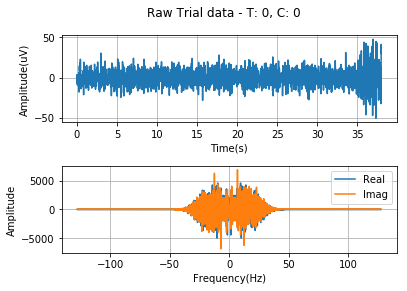

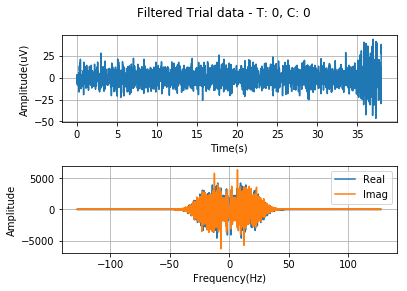

In [7]:
# Filter each trial data with butterworth bandpass filter and then butterworth notch filter
filtered_trial_data =[]
bandpass_range, bandpass_order = [0.1, 10] , 4  # Hz, 4th order
notch_freq, notch_order = 50, 2 # Hz, 2nd order

viz_trial_no = 0  # Visualization trial data no.
viz_chan_no = 0  # Visualization trial data's channel no.

for i in range(len(trial_data)):
    data = trial_data[i].copy()
    #data_band = butter_bandpass_filter(data[0][0]['X'].copy(), bandpass_range[0], bandpass_range[1], sampling_rate, bandpass_order)
    #data_notch = Implement_Notch_Filter(sampling_rate, notch_freq, data_band, order=notch_order)
    data_notch = Implement_Notch_Filter(sampling_rate, notch_freq, data[0][0]['X'].copy(), order=notch_order)
    data[0][0]['X'] = data_notch
    filtered_trial_data.append(data)

plt.close(1)
fig1 = plt.figure(1)
plt.clf()

plt.suptitle("Raw Trial data - T: " + str(viz_trial_no) + ", C: " + str(viz_chan_no))

plt.subplot(2, 1, 1)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude(uV)")
x_trial = trial_data[viz_trial_no][0][0]['X'][:, viz_chan_no]
plt.plot(np.arange(x_trial.size)/sampling_rate, x_trial)

plt.grid()
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(2, 1, 2)
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude")

x_fft_trial = np.fft.fft(x_trial, axis=0)
x_freq_trial = np.fft.fftfreq(x_trial.size, 1/sampling_rate)
plt.plot(x_freq_trial, x_fft_trial.real, label='Real')
plt.plot(x_freq_trial, x_fft_trial.imag, label='Imag')

plt.legend()
plt.grid()
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()

plt.close(2)
fig2 = plt.figure(2)
plt.clf()

plt.suptitle("Filtered Trial data - T: " + str(viz_trial_no) + ", C: " + str(viz_chan_no))

plt.subplot(2, 1, 1)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude(uV)")

x_filt = filtered_trial_data[viz_trial_no][0][0]['X'][:, viz_chan_no]
plt.plot(np.arange(x_filt.size)/sampling_rate, x_filt)

plt.grid()
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(2, 1, 2)
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude")

x_fft_filt = np.fft.fft(x_filt, axis=0)
x_freq_filt = np.fft.fftfreq(x_filt.size, 1/sampling_rate)
plt.plot(x_freq_filt, x_fft_filt.real, label='Real')
plt.plot(x_freq_filt, x_fft_filt.imag, label='Imag')

plt.legend()
plt.grid()
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()


## 3. Signal Extraction

1. From each trial data extract the signal($S^i_j(t)$) for each stimulus where 'i' is the trial no. and 'j' is the index of trial stimulus data for which the signal has been extracted.

2. Extract Target Class($Z^i_j$) for each corresponding $S^i_j(t)$.

### Specifications:

- __Total Signals Per Trial:__ 3840 (One for each stimulus of the trial)

- __Each Signal Duration:__ 1000ms(1sec or 250 samples)

- __Total Target Labels:__ [3840 signals x 1 target]

- __Target Class:__ 1-2(2)

In [8]:
# Extract signal for each stimulus of each trial data
trials = np.arange(len(filtered_trial_data)) # Trial data to be used
signal_dur = 1000 #ms
signal_length = int((sampling_rate * signal_dur)/1000)  # No. of samples in each stimulus signal
signals, sig_locations, sig_labels = [], [], []  # All stimulus signals, corresponding location in data and their targets

# For each trial data
for i in trials:
    data = filtered_trial_data[i].copy()  # Get the data
    printProgressBar(i+1, len(trials), prefix='Loaded')
    
    # Get index no. for the start of each stimulus
    #stim_indices = np.where(data[0][0]['y_stim'][:, 0] > 0)[0]
    stim_indices = []
    for j in range(1, data[0][0]['y_stim'].shape[0], 1):
        if data[0][0]['y_stim'][j-1, 0] == 0 and data[0][0]['y_stim'][j, 0] != 0:
            stim_indices.append(j)
    stim_indices = np.asarray(stim_indices)
    
    #print("Total Stimulus: " + str(stim_indices.shape))
    stim_indices = stim_indices[np.where(stim_indices + signal_length < data[0][0]['X'].shape[0])[0]]
    #print("Valid Stimulus: " + str(stim_indices.shape))
    
    # For each stimulus
    for j in range(len(stim_indices)):
        sig = data[0][0]['X'][stim_indices[j]:stim_indices[j]+signal_length, :]  # Extract the corresponding signal
        signals.append(sig)  # Add the signal to list
        sig_locations.append((i, stim_indices[j]))  # Add location of the signal to list
        sig_labels.append(data[0][0]['y'][stim_indices[j], 0])  # Add target label of the signal to list
signals = np.asarray(signals)
sig_locations = np.asarray(sig_locations)
sig_labels = np.asarray(sig_labels)
print("\n")
print("Total Signals: " + str(signals.shape))
print("Total Target: " + str(sig_labels.shape))
print("Total Locations: " + str(sig_locations.shape))
        

Loaded |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


Total Signals: (4165, 256, 8)
Total Target: (4165,)
Total Locations: (4165, 2)


In [9]:
np.where(filtered_trial_data[0][0][0]['y_stim'] > 0)[0].shape

(3840,)

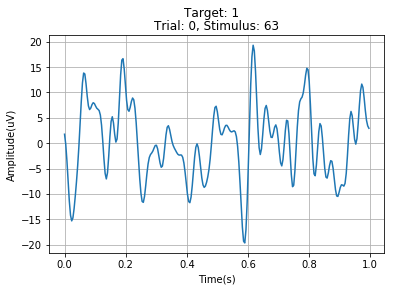

In [10]:
visualize_signal_no = 0
viz_chan_no = 1
plt.close(3)
fig3 = plt.figure(3)
plt.clf()

plt.suptitle("Target: " + str(sig_labels[visualize_signal_no]))
plt.title("Trial: " + str(sig_locations[visualize_signal_no, 0]) + ", Stimulus: " + str(sig_locations[visualize_signal_no, 1]))
plt.grid()
plt.xlabel("Time(s)")
plt.ylabel("Amplitude(uV)")

x_sig = signals[visualize_signal_no, :, viz_chan_no]
plt.plot(np.arange(x_sig.size)/sampling_rate, x_sig)

plt.show()

## 4. Baseline Removal and Averaging

1. From each signal/epoch ($S^i_j(t)$) remove artifacts/noise by excluding epochs whose peak amplitude exceeds 70 or -70 uV.


2. Perform Baseline correction using Average EEG Activity within 200msec preceeding each epoch.


3. Compute Average signal/epoch for Target signals and Non-Target Signals in order to compute the P300 Amplitude. Amplitude of the P300 potential in Cz was defined as the highest value of the difference between target and non-target average waveforms in the time interval 250–700msec. 

### Specifications:

- __Artifact Peak threshold__: -70uV and 70uV

- __Baseline Reference duration__: 200msec preceeding each epoch


In [11]:
# Remove artifacts from the signal and compute average waveform for target and non-target epochs

#=========================== a. Remove artifacts that exceed specified threshold =====================================
artifact_removal_thresh = [-70, 70]
signals_prep, sig_loc_prep, sig_lab_prep = [], [], []
for i in range(signals.shape[0]):
    printProgressBar(i+1, signals.shape[0], prefix='Removing Artifacts')
    peak_amp = [np.amin(signals[i, :, :]), np.amax(signals[i, :, :])]
    if  peak_amp[0] >= artifact_removal_thresh[0] and peak_amp[1] <= artifact_removal_thresh[1]:
        signals_prep.append(signals[i])
        sig_loc_prep.append(sig_locations[i])
        sig_lab_prep.append(sig_labels[i])
signals_prep, sig_loc_prep, sig_lab_prep = np.asarray(signals_prep), np.asarray(sig_loc_prep), np.asarray(sig_lab_prep)

print("Total Preprocessed Signals: " + str(signals_prep.shape))
print("Total Preprocessed Target: " + str(sig_lab_prep.shape))
print("Total Preprocessed Locations: " + str(sig_loc_prep.shape))

# ========================== b. Perform baseline correction using activity preceeding each epoch =======================
baseline_ref_dur = 200 # ms - Duration of the baseline reference for each epoch
baseline_ref_length = int((sampling_rate * baseline_ref_dur)/1000)
signals_br, sig_loc_br, sig_lab_br, sig_old_ind_br = [], [], [], []

for i in range(signals_prep.shape[0]):
    printProgressBar(i+1, signals_prep.shape[0], prefix='Correcting Baseline')
    trial_no = sig_loc_prep[i, 0]
    index_no = sig_loc_prep[i, 1]
    
    if index_no - baseline_ref_length >= 0:
        baseline_ref = filtered_trial_data[trial_no][0][0]['X'][index_no-baseline_ref_length:index_no, :]
        baseline_ref_avg = np.average(baseline_ref, axis=0).reshape((1, -1))
        baseline_removed_sig = np.subtract(signals_prep[i, :, :], baseline_ref_avg)
        signals_br.append(baseline_removed_sig)
        sig_loc_br.append(sig_loc_prep[i])
        sig_lab_br.append(sig_lab_prep[i])
        sig_old_ind_br.append(i)

print("\n")
signals_br, sig_loc_br, sig_lab_br = np.asarray(signals_br), np.asarray(sig_loc_br), np.asarray(sig_lab_br)
sig_old_ind_br = np.asarray(sig_old_ind_br)



    
print("\nTotal BaselineRemoved Signals: " + str(signals_br.shape))
print("Total BaselineRemoved Target: " + str(sig_lab_br.shape))
print("Total BaselineRemoved Locations: " + str(sig_loc_br.shape))
print("Total Old Indices: " + str(sig_old_ind_br.shape))

Removing Artifacts |███████████████████████████████---------------------------------------------------------------------| 32.0% 

Removing Artifacts |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Total Preprocessed Signals: (4084, 256, 8)
Total Preprocessed Target: (4084,)
Total Preprocessed Locations: (4084, 2)
Correcting Baseline |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 



Total BaselineRemoved Signals: (4084, 256, 8)
Total BaselineRemoved Target: (4084,)
Total BaselineRemoved Locations: (4084, 2)
Total Old Indices: (4084,)


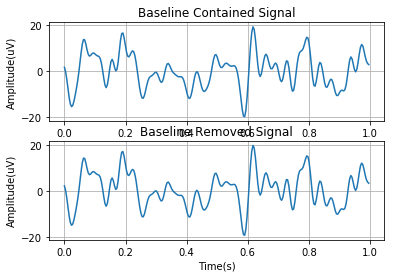

In [12]:
viz_sig_br_no = 0
viz_sig_prep_no = sig_old_ind_br[viz_sig_br_no]
viz_chan_no = 1


plt.close(4)
fig4 = plt.figure(4)
plt.clf()

plt.subplot(2, 1, 1)
plt.title("Baseline Contained Signal")
plt.grid()
plt.xlabel("Time(s)")
plt.ylabel("Amplitude(uV)")

plt.plot(np.arange(signals_prep[viz_sig_prep_no, :, viz_chan_no].size)/sampling_rate,
         signals_prep[viz_sig_prep_no, :, viz_chan_no])

plt.subplot(2, 1, 2)
plt.title("Baseline Removed Signal")
plt.grid()
plt.xlabel("Time(s)")
plt.ylabel("Amplitude(uV)")

plt.plot(np.arange(signals_br[viz_sig_br_no, :, viz_chan_no].size)/sampling_rate,
         signals_br[viz_sig_br_no, :, viz_chan_no])

plt.show()

Target Signals: (675, 256, 8)
Non-Target Signals: (3409, 256, 8)

 Avg. Target Signals: (256, 8)
Avg. Non-Target Signals: (256, 8)


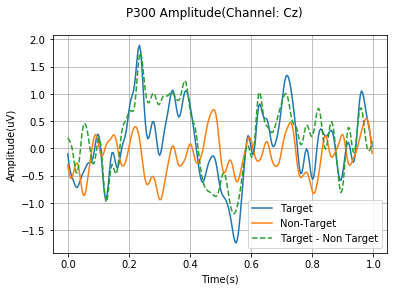

In [13]:
# Calculate Average waveform for target and non-target data
from scipy.signal import find_peaks
target_label, non_target_label = 2, 1
viz_chan_no = 1


target_signals = signals_br[np.where(sig_lab_br == target_label)[0], :, :]
non_target_signals = signals_br[np.where(sig_lab_br == non_target_label)[0], :, :]

print("Target Signals: " + str(target_signals.shape))
print("Non-Target Signals: " + str(non_target_signals.shape))

avg_target_signal = np.average(target_signals, axis=0)
pamp_peaks, _ = find_peaks(avg_target_signal[:, viz_chan_no], distance=int(avg_target_signal.shape[0]*0.2),
                          threshold=int(np.amax(avg_target_signal)*.50))
highest_peaks = np.argsort(avg_target_signal[pamp_peaks,viz_chan_no])[-3:]
avg_non_target_signal = np.average(non_target_signals, axis=0)

print("\n Avg. Target Signals: " + str(avg_target_signal.shape))
print("Avg. Non-Target Signals: " + str(avg_non_target_signal.shape))


plt.close(5)
fig5 = plt.figure(5)
plt.clf()
plt.suptitle("P300 Amplitude(Channel: " + str(sample_data[0][0]['channels'][0, viz_chan_no][0]) + ")")

plt.grid()
plt.xlabel("Time(s)")
plt.ylabel("Amplitude(uV)")

plt.plot(np.arange(avg_target_signal[:, viz_chan_no].size)/sampling_rate, avg_target_signal[:, viz_chan_no], label='Target')
plt.plot(np.arange(avg_non_target_signal[:, viz_chan_no].size)/sampling_rate, avg_non_target_signal[:, viz_chan_no], label='Non-Target')
plt.plot(np.arange(avg_non_target_signal[:, viz_chan_no].size)/sampling_rate,
         avg_target_signal[:, viz_chan_no] - avg_non_target_signal[:, viz_chan_no], '--', label='Target - Non Target')
plt.legend()

plt.show()



## 5. Resampling and Feature Extraction

1. For each baseline corrected signal/epoch($S^i_j(t)$) replace each sequence of 'n' samples with their mean. [n=12]

2. Create a Feature Vector for each $S^i_j(t)$ by concatenating the signal from all channels into a single feature vector.


### Specifications:

- Bin size for resampling: 12 samples

- Resampled signal shape: [21 x 8]

- Resampled signal duration: 984msec (Omitting last 4 sample points out of 256 for each signal/epoch)

- Feature Vector Shape for each resampled signal/epoch: [168]

In [14]:
# Calculate Feature Vector for each signal after resampling


#=======a. Resample baseline corrected signal by calculating mean for each sequence of specific subset of samples==========
resample_sequence_length = 12  # No. of samples for calculating mean
signals_resampled, sig_loc_resampled, sig_lab_resampled = [], [], []

for i in range(signals_br.shape[0]):
    printProgressBar(i+1, signals_br.shape[0], prefix='Resampling')
    data = signals_br[i, :, :].copy()
    resampled_data = np.empty((0, data.shape[1]), dtype=data.dtype)
    for j in range(0, data.shape[0], resample_sequence_length):
        if j+resample_sequence_length <= data.shape[0]:
            resampled_data = np.vstack((resampled_data, np.average(data[i:i+resample_sequence_length, :], axis=0)))
    signals_resampled.append(resampled_data)
    sig_loc_resampled.append(sig_loc_br[i])
    sig_lab_resampled.append(sig_lab_br[i])

print("\n")
signals_resampled, sig_loc_resampled, sig_lab_resampled = np.asarray(signals_resampled),np.asarray(sig_loc_resampled), np.asarray(sig_lab_resampled)
signals_resampled[signals_resampled == np.inf] = 0
signals_resampled[signals_resampled == -np.inf] = 0
signals_resampled = np.nan_to_num(signals_resampled, copy=True)
print("Total resampled Signals: " + str(signals_resampled.shape))
print("Total resampled Target: " + str(sig_lab_resampled.shape))
print("Total resampled Locations: " + str(sig_loc_resampled.shape))

# ============= b. Create Feature Vector by concatenating each channel to a single vector =======================

features = np.reshape(signals_resampled, (signals_resampled.shape[0], -1))
feature_loc = sig_loc_resampled.copy()
feature_lab = sig_lab_resampled.copy()

print("Total Features: " + str(features.shape))

E:\Anaconda3.5.2.0\lib\site-packages\numpy\lib\function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
E:\Anaconda3.5.2.0\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Resampling |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


Total resampled Signals: (4084, 21, 8)
Total resampled Target: (4084,)
Total resampled Locations: (4084, 2)
Total Features: (4084, 168)


## 6. Classification


1.  A sevenfold cross-validation is used to evaluate the binary accuracy (BA) of the classifier on each participant’s dataset.


2. For each iteration apply SWLDA(Stepwise Linear Discriminant Analysis) on the testing dataset to extract the 60 most significant control features and we assess the BA on the training dataset.. 

In [15]:
np.where(features == np.inf)

(array([], dtype=int64), array([], dtype=int64))

In [16]:
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
validation_folds = 7  # No. of validations for K-Fold Cross Validation
extracted_features = 60  # Total number of features to extract using training dataset

X = features.copy()
y = feature_lab.copy()  # Label for the dataset

kf = KFold(n_splits=validation_folds, shuffle=True, random_state=6069)

for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]
    clf = LinearDiscriminantAnalysis(n_components=extracted_features, solver='svd')
    clf.fit(X_train, y_train)
    
    print("Accuracy: {0:.2f}%".format(clf.score(X_test, y_test) * 100))
    



E:\Anaconda3.5.2.0\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy: 84.59%
Accuracy: 82.02%
Accuracy: 86.47%
Accuracy: 83.53%
Accuracy: 84.56%
Accuracy: 80.79%
Accuracy: 82.16%
